very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=1
dm=False


if dm:
  denses=[100,50,20]
else:
  denses=[]


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[7]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(6265, 28, 28, 1)
(6265, 10)
(8972, 28, 28, 1)
(8972, 10)
(1028, 28, 28, 1)
(1028, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
sb=[layers.Dense(dd,use_bias=False) for dd in denses]
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),*sb,
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 100)       100       
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 50)        5000      
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 20)        1000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 15680     
Total params: 21,780
Trainable params: 21,780
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
45/45 [==============================] - 6s 126ms/step - loss: 0.1028 - val_loss: 0.0406
Epoch 2/5
45/45 [==============================] - 5s 121ms/step - loss: 0.0473 - val_loss: 0.0401
Epoch 3/5
45/45 [==============================] - 5s 122ms/step - loss: 0.0462 - val_loss: 0.0401
Epoch 4/5
45/45 [==============================] - 5s 121ms/step - loss: 0.0449 - val_loss: 0.0393
Epoch 5/5
45/45 [==============================] - 5s 122ms/step - loss: 0.0435 - val_loss: 0.0382


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(8972, 1)
(1028, 1)


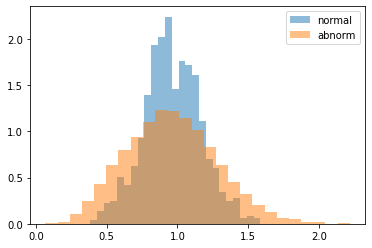

In [ ]:
import matplotlib.pyplot as plt
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
p=model.predict(x_train)


In [ ]:
mp=np.mean(p,axis=0)
da=np.abs(pa-mp)
dn=np.abs(pn-mp)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(8972,) (1028,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.16109134 0.12400485
abnorm 0.25560522 0.19054215


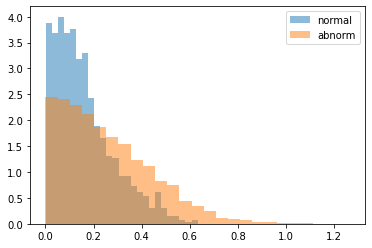

In [ ]:
plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
y_score=np.concatenate((dfn,dfa),axis=0)
y_true=np.concatenate((np.zeros_like(dfn),np.ones_like(dfa)),axis=0)

print(y_true.shape,y_score.shape)

(10000,) (10000,)


In [ ]:
from sklearn.metrics import roc_auc_score as rauc

auc=rauc(y_true,y_score)
print(auc)

0.6456335837738161
